In [1]:
train_directory = 'Emotions Dataset/train'
val_directory = "Emotions Dataset/test"
CLASS_NAMES = ["angry" , "happy" , "sad"]

In [2]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Resizing , Rescaling
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model , load_model 
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import  GlobalAveragePooling2D,Activation,MaxPooling2D, RandomFlip,RandomContrast, RandomRotation,BatchNormalization,Dropout , Conv2D ,InputLayer,Input,Layer,  MaxPool2D , Dense, Flatten
from tensorflow.keras.losses import CategoricalCrossentropy 
from tensorflow.keras.metrics import CategoricalAccuracy , TopKCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback ,ModelCheckpoint

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.


In [5]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=1,#CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


### Data Visulization

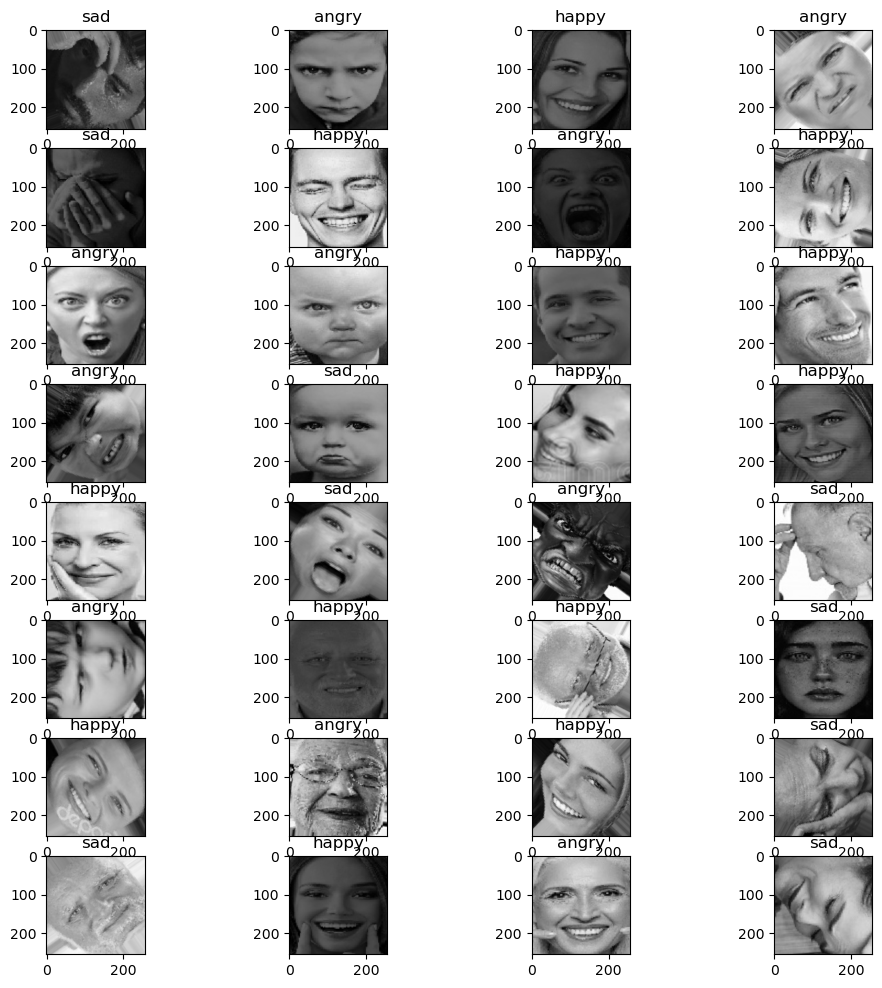

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize= (12,12))

for images , labels in train_dataset.take(1):
    for i in range(32):
        ax = plt.subplot(8,4, i+1)
        plt.imshow(images[i]/255)
        plt.title(CLASS_NAMES[tf.argmax(labels[i] , axis =0 ).numpy()])
    
    

## Data Augmentation

In [7]:
augment_layers = tf.keras.Sequential(
[ 
     RandomRotation(factor = (0.025 , 0.02501),),
    RandomFlip(mode ="horizontal"),
    RandomContrast(factor = 0.1)
])

In [8]:

def augment_layer (image , label):
    return augment_layers(image , training = True), label
    

In [9]:
#asynchronously fetch batches of data in the background while the model is training
training_dataset = (train_dataset
                    .map(augment_layer , num_parallel_calls=tf.data.AUTOTUNE)
                    .prefetch(tf.data.AUTOTUNE))

In [10]:
validation_dataset = (val_dataset.prefetch(tf.data.AUTOTUNE))

## Modeling

## RESNET 34

## CustomConv2D

In [11]:
class CustomConv2D(Layer):
    def __init__(self , n_filters , kernel_size , n_strides , padding='valid'):
        super(CustomConv2D , self).__init__(name = 'custom_conv2d')
        
        self.conv = Conv2D(
            filters= n_filters , 
            kernel_size= kernel_size,
            activation='relu',
            strides = n_strides , 
            padding = padding
        )
        self.batch_norm = BatchNormalization()
        
    def call(self ,x, training = True):
        x = self.conv(x)
        x = self.batch_norm(x , training)
        return x

In [12]:
class ResidualBlock(Layer):
    def __init__(self , n_channels , n_strides = 1):
        super(ResidualBlock , self).__init__(name = 'res_block')
        self.dotted = (n_strides !=1)
        self.custom_conv_1 = CustomConv2D(n_channels , 3 , n_strides , padding='same'),
        self.custom_conv_2 = CustomConv2D(n_channels , 3 , 1 ,padding = 'same'),
        self.activation = Activation('relu')
        if self.dotted :
            self.custom_conv3 = CustomConv2D(n_channels , 1 , n_strides)
        
        def call(self , input ,training):
            x = self.custom_conv_1(input , training)
            x = self.custom_conv_2(x , training)
            if self.dotted:
                x_add = self.custom_conv3(input ,training)
                x_add = Add()([x , x_add])
            else :
                x_add = Add()([x , input])
            return self.activation(x_add)
                

In [13]:
class ResNet34(Model):
    def __init__(self,):
        super(ResNet34, self).__init__(name = 'resnet_34')

        self.conv_1 = CustomConv2D(64, 7, 2, padding = 'same')
        self.max_pool = MaxPooling2D(3,2)

        self.conv_2_1 = ResidualBlock(64)
        self.conv_2_2 = ResidualBlock(64)
        self.conv_2_3 = ResidualBlock(64)

        self.conv_3_1 = ResidualBlock(128, 2)
        self.conv_3_2 = ResidualBlock(128)
        self.conv_3_3 = ResidualBlock(128)
        self.conv_3_4 = ResidualBlock(128)

        self.conv_4_1 = ResidualBlock(256, 2)
        self.conv_4_2 = ResidualBlock(256)
        self.conv_4_3 = ResidualBlock(256)
        self.conv_4_4 = ResidualBlock(256)
        self.conv_4_5 = ResidualBlock(256)
        self.conv_4_6 = ResidualBlock(256)

        self.conv_5_1 = ResidualBlock(512, 2)
        self.conv_5_2 = ResidualBlock(512)
        self.conv_5_3 = ResidualBlock(512)

        self.global_pool = GlobalAveragePooling2D()

        self.fc_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')

    def call(self, x, training = True):
        x = self.conv_1(x)
        x = self.max_pool(x)

        x = self.conv_2_1(x, training)
        x = self.conv_2_2(x, training)
        x = self.conv_2_3(x, training)

        x = self.conv_3_1(x, training)
        x = self.conv_3_2(x, training)
        x = self.conv_3_3(x, training)
        x = self.conv_3_4(x, training)

        x = self.conv_4_1(x, training)
        x = self.conv_4_2(x, training)
        x = self.conv_4_3(x, training)
        x = self.conv_4_4(x, training)
        x = self.conv_4_5(x, training)
        x = self.conv_4_6(x, training)

        x = self.conv_5_1(x, training)
        x = self.conv_5_2(x, training)
        x = self.conv_5_3(x, training)

        x = self.global_pool(x)

        return self.fc_3(x)

## Transfer Learning with EfficientNet

In [14]:
efficient_net = tf.keras.applications.efficientnet.EfficientNetB5(
include_top=False,
weights='imagenet',
    input_shape=(CONFIGURATION['IM_SIZE'] , CONFIGURATION['IM_SIZE'],3)
    
)

In [15]:
#make it non trainable
efficient_net.trainable = False

In [16]:
model_ef = tf.keras.Sequential(
[
    Input(shape = (CONFIGURATION['IM_SIZE'] , CONFIGURATION['IM_SIZE'] , 3)),
    efficient_net , 
    GlobalAveragePooling2D() , 
    Dense(CONFIGURATION['N_DENSE_1'] , activation = 'relu'),
    BatchNormalization() , 
    Dense(CONFIGURATION['N_DENSE_2'] , activation='relu'),
    Dense(CONFIGURATION['NUM_CLASSES'] , activation='softmax')
])

In [17]:
model_ef.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional  (None, 8, 8, 2048)        28513527  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 128)               131200    
                                                      

## Finetuning 

In [18]:
# efficient_net.trainable = False

In [19]:
# input = Input(shape = (CONFIGURATION['IM_SIZE'] , CONFIGURATION['IM_SIZE'] , 3)),
# x = efficient_net(input , training = False) , 
# x = GlobalAveragePooling2D()(x) , 
# x = Dense(CONFIGURATION['N_DENSE_1'] , activation = 'relu')(x),
# x = BatchNormalization()(x) , 
# x = Dense(CONFIGURATION['N_DENSE_2'] , activation='relu')(x),
# x = Dense(CONFIGURATION['NUM_CLASSES'] , activation='softmax')(x)

# finetuned_model = Model(input , output)

In [18]:
resnet_34 = ResNet34()

In [19]:
resize_rescale_layers = tf.keras.Sequential([
    
    Resizing(256 , 256 ),
    Rescaling(1.0/255)
])

In [20]:
IM_SIZE = 256
dropout_rate = 0.2
model = tf.keras.Sequential(
[
    InputLayer(input_shape = (None , None ,3 )), 
    resize_rescale_layers,
    Conv2D(filters = 3 , kernel_size=5 , strides=1 ,activation='relu' ,padding='valid' ,
           kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    BatchNormalization(),
    MaxPool2D(pool_size=2 , strides=1),
    Dropout(rate = dropout_rate),  
    Conv2D( filters=8 ,kernel_size=5 , strides=1 , padding='valid' ,kernel_regularizer=tf.keras.regularizers.L2(0.01), activation='relu' ),
    MaxPool2D(pool_size=2 , strides=2),
    Flatten(),
    Dense(216 , activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    BatchNormalization(),
    Dropout(rate = dropout_rate),
    Dense(64 ,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    BatchNormalization(),
    Dense(3 , activation='softmax')
    
    
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_36 (Conv2D)          (None, 252, 252, 3)       228       
                                                                 
 batch_normalization_37 (Ba  (None, 252, 252, 3)       12        
 tchNormalization)                                               
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 251, 251, 3)       0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 251, 251, 3)       0         
                                                                 
 conv2d_37 (Conv2D)          (None, 247, 247, 8)      

In [21]:
loss_function = CategoricalCrossentropy()

In [22]:
n_sample_0 = 1525 #angry
n_sample_1 = 3019 #happy
n_sample_2 = 2255 #sad

In [23]:
class_weights = {
    0: 6799 /n_sample_0, 1:6799/n_sample_1 , 2:6799/n_sample_2
}

In [24]:
print(class_weights)

{0: 4.458360655737705, 1: 2.2520702219277906, 2: 3.015077605321508}


In [25]:
metrics = [CategoricalAccuracy(name = 'accuracy') , TopKCategoricalAccuracy(k =2 , name = 'top_k_accuracy')]

In [26]:
class LossCallback (Callback):
    def on_epoch_end(self , epoch , logs):
         print("For the epoch number {} the model has a loss of {}".format(epoch , logs['loss']))
            
    def on_batch_end (self , batch , logs):
        print("\n For batch number {} , the model has a loss of {}".format(batch+1 , logs ))

checkpoint_callback = ModelCheckpoint(
    'best_weights',
    monitor='val_accuracy', verbose =1,
    mode = 'max',
    save_best_only = True
)

In [27]:
# model.compile(
# optimizer=Adam(learning_rate=0.01) , 
#     loss=loss_function,
#     metrics=metrics
# )
# resnet_34.compile(
#     optimizer=Adam(learning_rate=CONFIGURATION['LEARNING_RATE']*10),
#     loss= loss_function,
#     metrics=metrics
# )
model_ef.compile(
    optimizer=Adam(learning_rate=CONFIGURATION['LEARNING_RATE']/10),
    loss= loss_function,
    metrics=metrics
)

In [ ]:
history = model_ef.fit(
train_dataset , 
validation_data=validation_dataset , 
epochs=1 , 
    class_weight=class_weights,
callbacks=[checkpoint_callback , LossCallback()],
verbose = 1,
)



 For batch number 1 , the model has a loss of {'loss': 10.934539794921875, 'accuracy': 0.34375, 'top_k_accuracy': 0.5}
  1/213 [..............................] - ETA: 67:35:29 - loss: 10.9345 - accuracy: 0.3438 - top_k_accuracy: 0.5000

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss' , 'val_loss'])
plt.show()

In [28]:
model_ef.load_weights('best_weights')

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy' , 'val_accuracy'])
plt.show()

NameError: name 'history' is not defined

In [29]:
model_ef.evaluate(validation_dataset)


2278/2278 [==============================] - 526s 229ms/step - loss: 0.4928 - accuracy: 0.7959 - top_k_accuracy: 0.9359


[0.49283015727996826, 0.7958735823631287, 0.9359086751937866]

## Testing

In [39]:

import cv2
test_image = cv2.imread('Emotions Dataset/train/happy/101883.jpg')
test_image = cv2.resize(test_image,(256,256))
im = tf.constant(test_image , dtype=tf.float32)
im = tf.expand_dims(im , axis = 0)


In [40]:
print(CLASS_NAMES[tf.argmax(model_ef(im) , axis =-1).numpy()[0]])

happy


In [37]:
# plt.figure(figsize = (12,12))
# for images , labels in validation_dataset.take(1):
#     for i in range(16):
#         ax = plt.subplot(4,4,i+1)
#         plt.imshow(images[i]/255.)
#         plt.title("True label:"+CLASS_NAMES[tf.argmax(labels[i] , axis = 0).numpy()] + "\n" 
#                   + "Predicted Label:" +  
#                    CLASS_NAMES[tf.argmax(model_ef(tf.expand_dims(images[i], axis = 0)) , axis =-1).numpy()[0]] )


### Confusion Matrix

In [41]:
predicted = []
labels  = []
for im,label in validation_dataset:
    predicted.append(model_ef(im))
    labels.append(label.numpy())

In [42]:
print(np.argmax(labels[:-1] , axis= -1))

[[1]
 [1]
 [1]
 ...
 [2]
 [1]
 [1]]


In [43]:
print(np.argmax(labels[:-1] , axis=-1).flatten())
print(np.argmax(predicted[:-1] , axis=-1).flatten())

[1 1 1 ... 2 1 1]
[1 1 1 ... 2 1 1]


In [44]:
pred = np.argmax(predicted[:-1] , axis=-1).flatten()
lab = np.argmax(labels[:-1] , axis=-1).flatten()

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [46]:
cm = confusion_matrix(lab , pred)
print(cm)

[[315  55 144]
 [ 30 848 128]
 [ 46  62 649]]


Text(0.5, 58.7222222222222, 'Predicted')

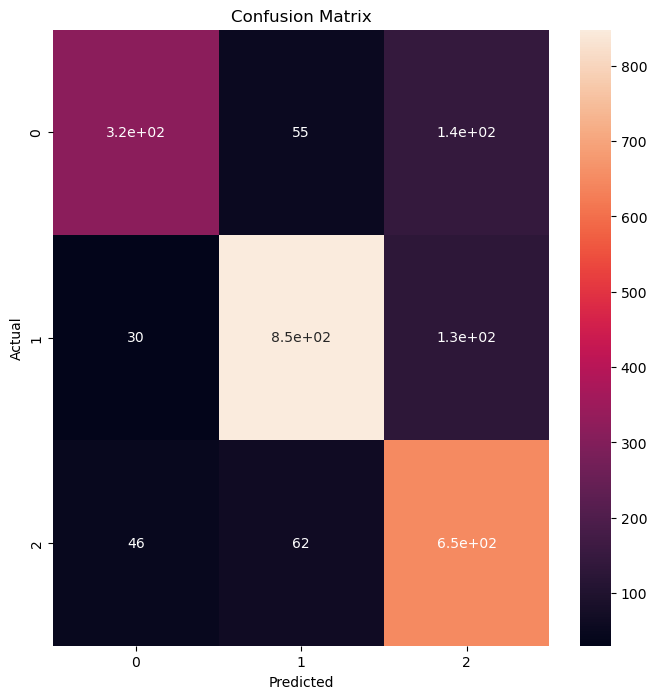

In [47]:
plt.figure(figsize = (8 , 8))
sns.heatmap(cm , annot = True)
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')